In [1]:
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

import pandas as pd
import numpy as np

from pathlib import Path
import csv

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from imageio import imread
import marginal

from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [2]:
def get_marginal_mean(arr,dim="x", meanNN_TF=False):
    '''
    E(x) = int x f(x) dx
    
    arr      : np.array containing 2-d heatmap, shape is (height, width) 
    dim      : if "x", the marginal mean of X (width) is calcualted
                if "y", the marginal mean of Y (height)is calcualted 
    meanNN_TF: if False, the marginal mean is calculated using all the pixels.
                if True, then the marginal mean is calculated using the neighboor of the high marginal density region.
                The "neighboor" is calculated in two steps:
                (1) order the intensity of the marginal density 
                in the decreasing manner, 
                (2) include the top densities until the corresponding pixel coordinate hits the pixel border.
                
    '''
    if dim == "x":
        axis = 0
    elif dim == "y":
        axis = 1
    mardens = arr.sum(axis=axis)
    asort   = np.argsort(mardens)[::-1]
    
    if meanNN_TF:
        Npixel = np.min(np.where((asort == 0) | (asort == (len(asort)-1) ))) + 1
    else: 
        Npixel = -1 
    mardens = mardens[asort][:Npixel]
    mardens = mardens / np.sum(mardens) ## rescale so that marginal density adds up to 1
    
    xcoor   = asort[:Npixel]
    
    meanx   = np.sum((xcoor*mardens)[:Npixel])
    return(meanx)
    
def get_marginal_sd(arr,dim="x",verbose=False,meanNN_TF=False):
    '''
        E( (x - barx)**2 ) = int (x-barx)**2 f(x) dx
        
    arr     : np.array containing 2-d heatmap, shape is (height, width) 
    dim     : if "x", the marginal mean of X (width) is calcualted
                if "y", the marginal mean of Y (height)is calcualted 
    meanNN_TF: if False, the marginal mean is calculated using all the pixels.
                if True, then the marginal mean is calculated using the neighboor of the high marginal density region.
                The "neighboor" is calculated in two steps:
                (1) order the intensity of the marginal density 
                in the decreasing manner, 
                (2) include the top densities until the corresponding pixel coordinate hits the pixel border.
    '''
    if dim == "x":
        axis = 0
    elif dim == "y":
        axis = 1
    mardens = arr.sum(axis=axis)
    xcoor   = np.arange(len(mardens))
    
    meanx   = get_marginal_mean(arr, dim=dim, meanNN_TF=meanNN_TF)
    varx    = np.sqrt(np.sum((xcoor - meanx)**2*mardens))
    if verbose:
        print("{} total dens = {:4.3f}, mean = {:5.2f}".format(
                dim,
                np.sum(mardens),
                meanx)
                )
    return(varx)
def get_cov(arr,verbose=True,meanNN_TF=False):
    '''
        E( (x - barx)*(y - bary) ) = int (x-barx)*(y - bary) f(x,y) dxdy
        
    arr     : np.array containing 2-d heatmap, shape is (height, width) 
    meanNN_TF: if False, the marginal mean is calculated using all the pixels.
                if True, then the marginal mean is calculated using the neighboor of the high marginal density region.
                The "neighboor" is calculated in two steps:
                (1) order the intensity of the marginal density 
                in the decreasing manner, 
                (2) include the top densities until the corresponding pixel coordinate hits the pixel border.
                
                recommended to set True to improve the variance estimate performance when not all the density is included in the heatmap image.
                
    '''

    ## prepare the storage space
    x_coor_mat = np.zeros_like(arr)
    for icol in range(x_coor_mat.shape[1]):
        x_coor_mat[:, icol] = icol
        
    y_coor_mat = np.zeros_like(arr)
    for irow in range(y_coor_mat.shape[0]):
        y_coor_mat[irow, :] = irow
        
    meanx   = get_marginal_mean(arr, dim = "x", meanNN_TF=meanNN_TF) ## scalar
    meany   = get_marginal_mean(arr, dim = "y", meanNN_TF=meanNN_TF) ## scalar 

    cov     = np.sum((x_coor_mat - meanx)*(y_coor_mat - meany )*arr)

    return(cov)

def fit_PCA(cov):
    '''
    fit PCA on the covariance matrix
    cov : n by n square covariance matrix
    
    Output: ([e_1,e_2,..,e_n], D)
    
    cov = P D P^T
    where P    = [pc1, pc2,..., pc_n]
          pc_k = principal component vector (eigenvector) of length n
          D    = [[e_1, 0,....0],
                  [0, e_2,....0],
                  ...,
                  [0,0,..., e_n]]
         where e_1 > e_2 >,... e_n
    
    '''
    eig_vals, eig_vecs = np.linalg.eig(cov)
    ## reorder in the increasing order of eigenvalues
    asort = np.argsort(eig_vals)[::-1]
    eig_vals, eig_vecs = eig_vals[asort], eig_vecs[:,asort]
    
    return(eig_vals, eig_vecs)

In [3]:
def read_grayscale_pngs(path, width=20, height=13):
    path = Path(path)
    if not path.exists():
        print("Path doesn't exist")
        return None

    # print(len([name for name in os.listdir('{}/.'.format(path)) if os.path.isfile(name)]))
    num_files = len(list(path.glob('**/*.png'))) # Calculate amount of files in directory
    # num_files = len([f for f in path.iterdir() if path.joinpath(f).is_file()]) # Calculate amount of files in directory

    ids = np.empty(num_files)
    images = np.empty((num_files, 13, 20))

    for i, image_path in enumerate(path.glob('**/*.png')):
        images[i] = np.array(imread(image_path))[:, :, 0] # Pixel data: It's grayscale so take only Red values from [R, G, B, A]
    return images

In [4]:
legal = np.concatenate((read_grayscale_pngs("out/legal/orig"), read_grayscale_pngs("out/legal/mirrored")))
illegal = np.concatenate((read_grayscale_pngs("out/illegal/orig"), read_grayscale_pngs("out/illegal/mirrored")))

legal_test = read_grayscale_pngs("testing_recurrent/legal")
illegal_test = read_grayscale_pngs("testing_recurrent/illegal")


In [5]:
legal_features = pd.DataFrame({
    "min": np.min(legal, axis=(1,2)),
    "max": np.max(legal, axis=(1,2)),
    "mean": np.mean(legal, axis=(1,2)),
    "var": np.var(legal, axis=(1,2)),
    "sum": np.sum(legal, axis=(1,2)),
    "ptp": np.ptp(legal, axis=(1,2)),
    "std": np.std(legal, axis=(1,2)),
    "trace": np.trace(legal, axis1=1, axis2=2),

    "mmeanx": np.array([marginal.mean(image, dim='x', meanNN_TF=False) for image in legal]),
    "mmeanxTF": np.array([marginal.mean(image, dim='x', meanNN_TF=True) for image in legal]),

    "msdx": np.array([marginal.std(image, dim='x', meanNN_TF=False) for image in legal]),
    "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in legal]),

    "mmeany": np.array([marginal.mean(image, dim='y', meanNN_TF=False) for image in legal]),
    "mmeanyTF": np.array([marginal.mean(image, dim='y', meanNN_TF=True) for image in legal]),

    "msdy": np.array([marginal.std(image, dim='y', meanNN_TF=False) for image in legal]),
    "msdyTF": np.array([marginal.std(image, dim='y', meanNN_TF=True) for image in legal]),

    "cov": np.array([get_cov(image, meanNN_TF=False) for image in legal]),
    "covTF": np.array([get_cov(image, meanNN_TF=True) for image in legal]),

    "target": 0
})

illegal_features = pd.DataFrame({
    "min": np.min(illegal, axis=(1,2)),
    "max": np.max(illegal, axis=(1,2)),
    "mean": np.mean(illegal, axis=(1,2)),
    "var": np.var(illegal, axis=(1,2)),
    "sum": np.sum(illegal, axis=(1,2)),
    "ptp": np.ptp(illegal, axis=(1,2)),
    "std": np.std(illegal, axis=(1,2)),
    "trace": np.trace(illegal, axis1=1, axis2=2),

    "mmeanx": np.array([marginal.mean(image, dim='x', meanNN_TF=False) for image in illegal]),
    "mmeanxTF": np.array([marginal.mean(image, dim='x', meanNN_TF=True) for image in illegal]),

    "msdx": np.array([marginal.std(image, dim='x', meanNN_TF=False) for image in illegal]),
    "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in illegal]),

    "mmeany": np.array([marginal.mean(image, dim='y', meanNN_TF=False) for image in illegal]),
    "mmeanyTF": np.array([marginal.mean(image, dim='y', meanNN_TF=True) for image in illegal]),

    "msdy": np.array([marginal.std(image, dim='y', meanNN_TF=False) for image in illegal]),
    "msdyTF": np.array([marginal.std(image, dim='y', meanNN_TF=True) for image in illegal]),

    "cov": np.array([get_cov(image, meanNN_TF=False) for image in illegal]),
    "covTF": np.array([get_cov(image, meanNN_TF=True) for image in illegal]),

    "target": 1
})

features = pd.concat((illegal_features, legal_features))

In [6]:
legal_test_features = pd.DataFrame({
    "min": np.min(legal_test, axis=(1,2)),
    "max": np.max(legal_test, axis=(1,2)),
    "mean": np.mean(legal_test, axis=(1,2)),
    "var": np.var(legal_test, axis=(1,2)),
    "sum": np.sum(legal_test, axis=(1,2)),
    "ptp": np.ptp(legal_test, axis=(1,2)),
    "std": np.std(legal_test, axis=(1,2)),
    "trace": np.trace(legal_test, axis1=1, axis2=2),

    "mmeanx": np.array([get_marginal_mean(image, dim='x', meanNN_TF=False) for image in legal_test]),
    "mmeanxTF": np.array([get_marginal_mean(image, dim='x', meanNN_TF=True) for image in legal_test]),

    "msdx": np.array([get_marginal_sd(image, dim='x', meanNN_TF=False) for image in legal_test]),
    "msdxTF": np.array([get_marginal_sd(image, dim='x', meanNN_TF=True) for image in legal_test]),

    "mmeany": np.array([get_marginal_mean(image, dim='y', meanNN_TF=False) for image in legal_test]),
    "mmeanyTF": np.array([get_marginal_mean(image, dim='y', meanNN_TF=True) for image in legal_test]),

    "msdy": np.array([get_marginal_sd(image, dim='y', meanNN_TF=False) for image in legal_test]),
    "msdyTF": np.array([get_marginal_sd(image, dim='y', meanNN_TF=True) for image in legal_test]),

    "cov": np.array([get_cov(image, meanNN_TF=False) for image in legal_test]),
    "covTF": np.array([get_cov(image, meanNN_TF=True) for image in legal_test]),

    "target": 0
})

illegal_test_features = pd.DataFrame({
    "min": np.min(illegal_test, axis=(1,2)),
    "max": np.max(illegal_test, axis=(1,2)),
    "mean": np.mean(illegal_test, axis=(1,2)),
    "var": np.var(illegal_test, axis=(1,2)),
    "sum": np.sum(illegal_test, axis=(1,2)),
    "ptp": np.ptp(illegal_test, axis=(1,2)),
    "std": np.std(illegal_test, axis=(1,2)),
    "trace": np.trace(illegal_test, axis1=1, axis2=2),

    "mmeanx": np.array([get_marginal_mean(image, dim='x', meanNN_TF=False) for image in illegal_test]),
    "mmeanxTF": np.array([get_marginal_mean(image, dim='x', meanNN_TF=True) for image in illegal_test]),

    "msdx": np.array([get_marginal_sd(image, dim='x', meanNN_TF=False) for image in illegal_test]),
    "msdxTF": np.array([get_marginal_sd(image, dim='x', meanNN_TF=True) for image in illegal_test]),

    "mmeany": np.array([get_marginal_mean(image, dim='y', meanNN_TF=False) for image in illegal_test]),
    "mmeanyTF": np.array([get_marginal_mean(image, dim='y', meanNN_TF=True) for image in illegal_test]),

    "msdy": np.array([get_marginal_sd(image, dim='y', meanNN_TF=False) for image in illegal_test]),
    "msdyTF": np.array([get_marginal_sd(image, dim='y', meanNN_TF=True) for image in illegal_test]),

    "cov": np.array([get_cov(image, meanNN_TF=False) for image in illegal_test]),
    "covTF": np.array([get_cov(image, meanNN_TF=True) for image in illegal_test]),

    "target": 1
})

test_features = pd.concat((illegal_test_features, legal_test_features))

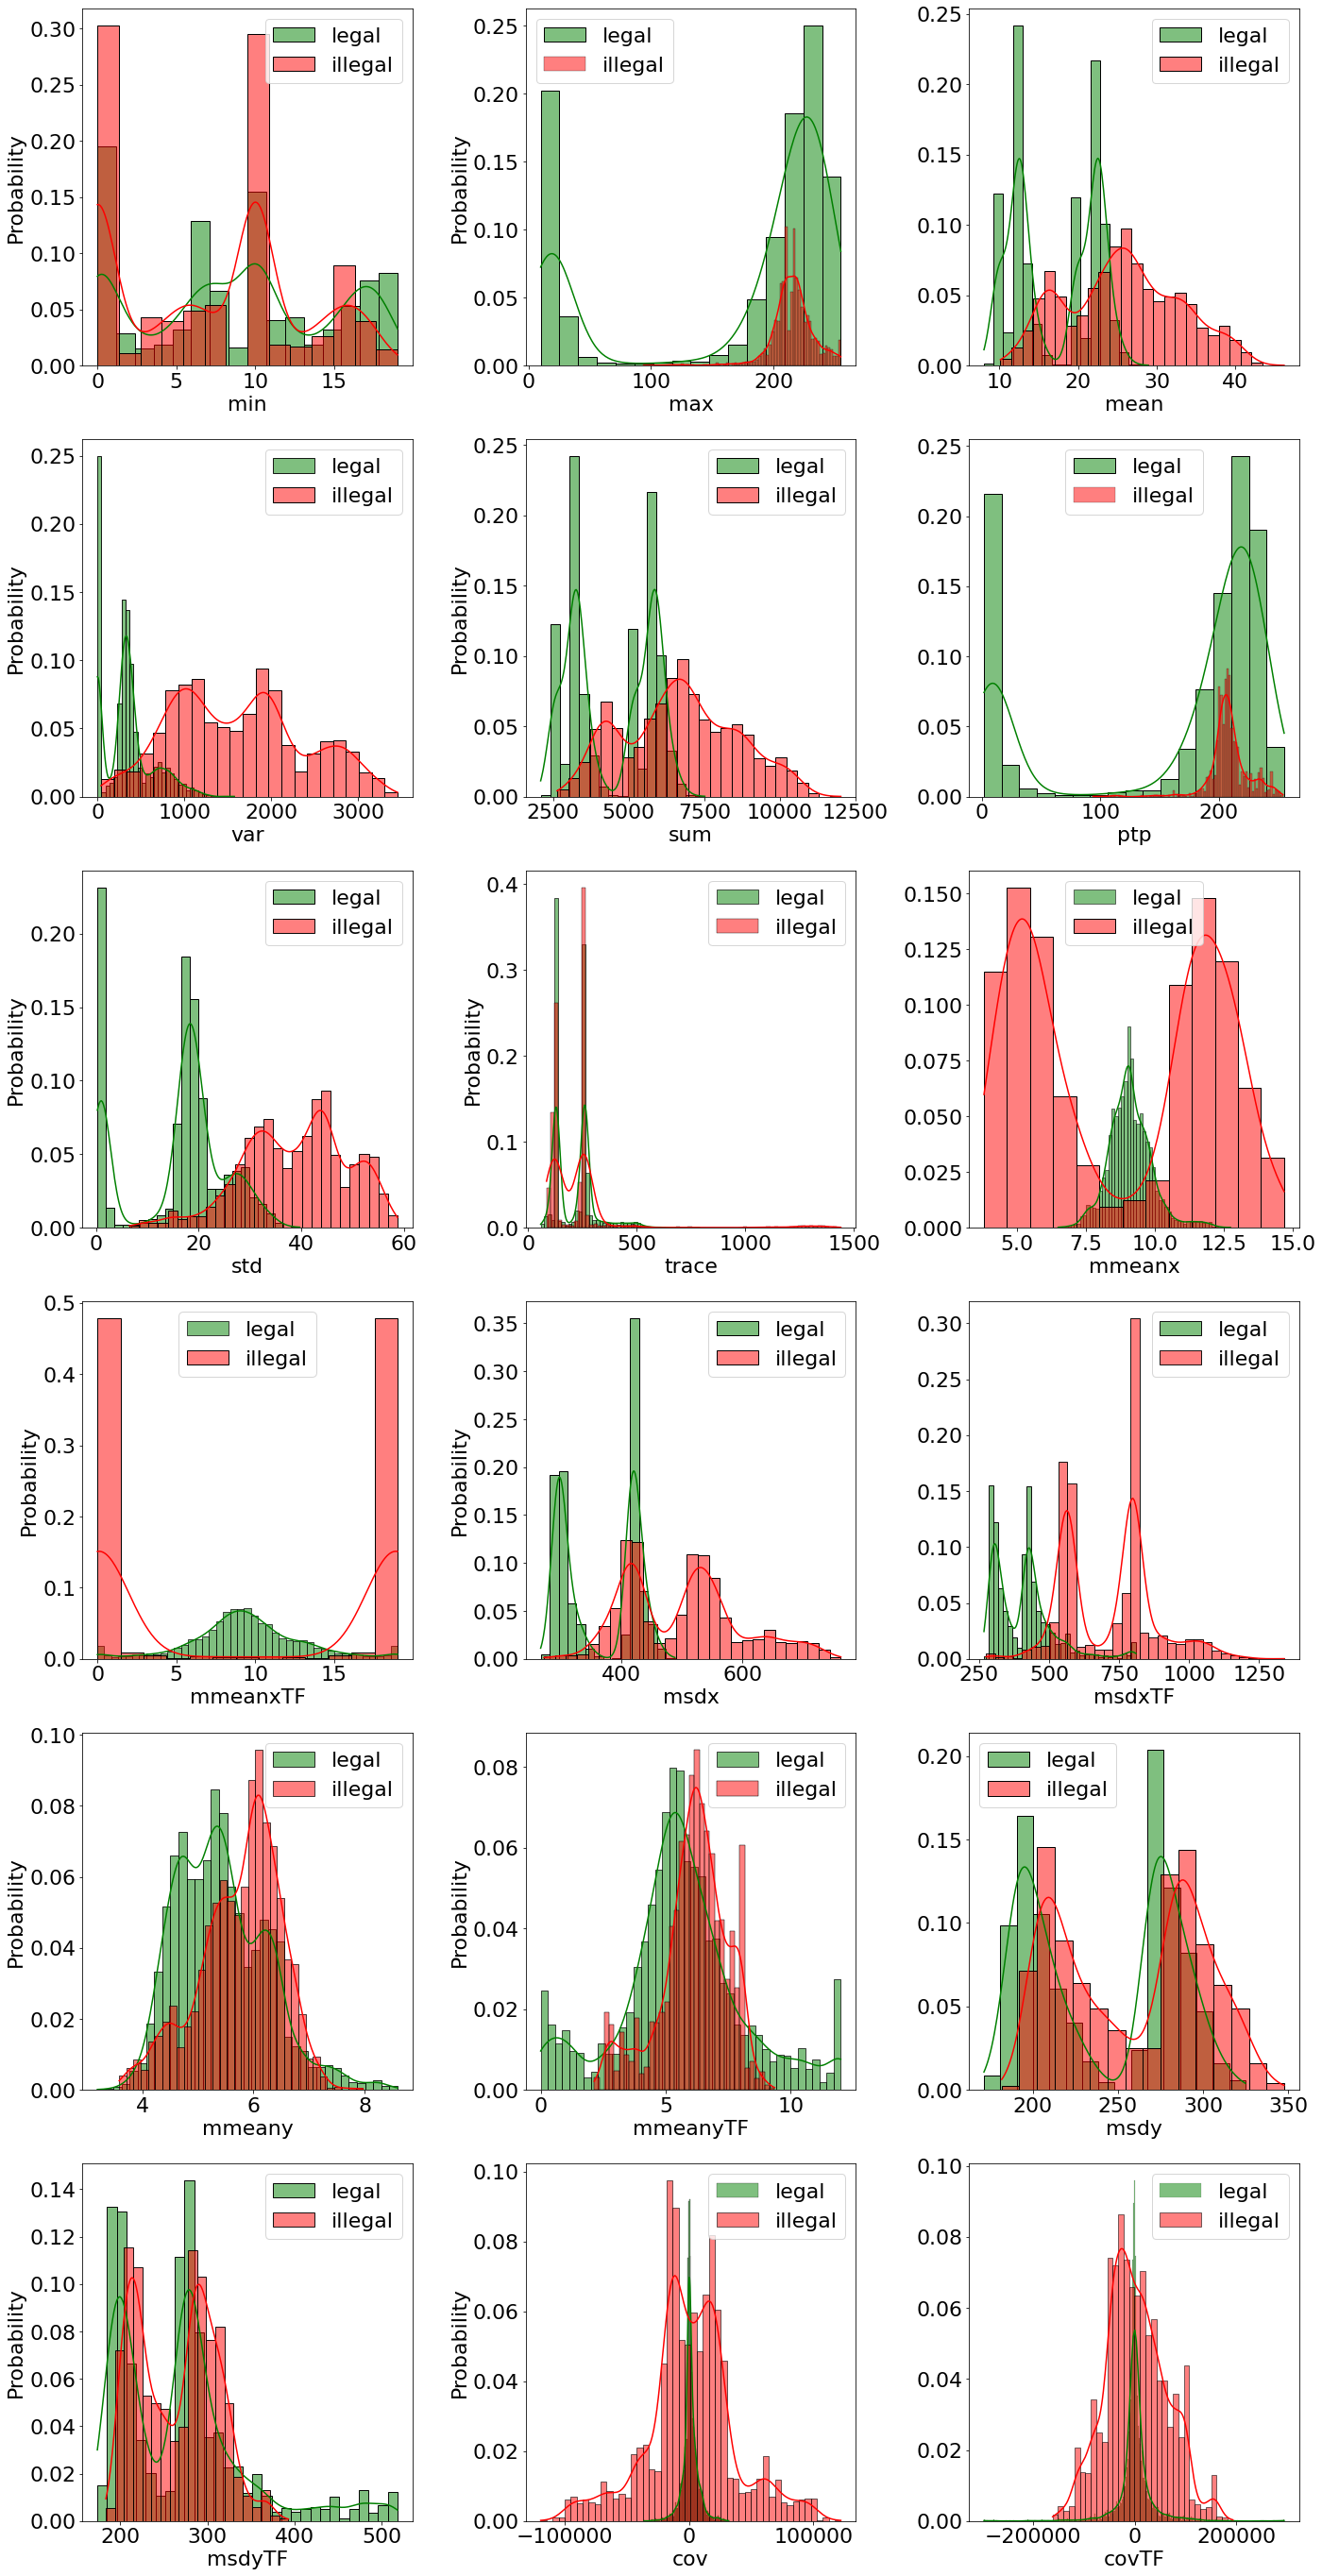

In [7]:
fig = plt.figure(figsize=(20, 40))
plt.rcParams.update({'font.size': 22})
i = 1
for feature in features.columns[: features.columns.slice_locs(end='covTF')[1]]: # Cycle through columns until and including "trace"
    plt.subplot(6, 3, i)
    sns.histplot(data=legal_features, x=feature, kde=True, stat="probability", color='g', label='legal')
    sns.histplot(data=illegal_features, x=feature, kde=True, stat="probability", color='r', label='illegal')
    if i % 3 == 0:
        plt.ylabel(None)
    plt.legend(loc='best')
    i += 1
# fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('figures/ai_ml_feature_distribution.pdf')

<Figure size 2160x2880 with 0 Axes>

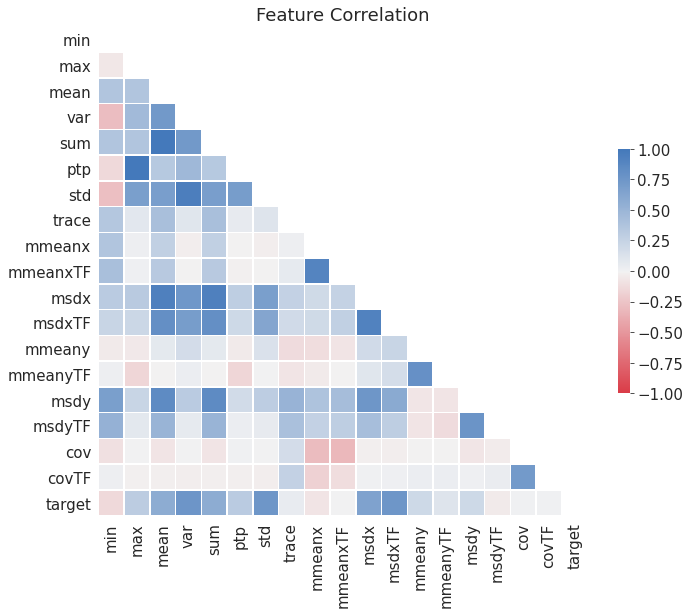

In [9]:
plt.figure(figsize=(30,40))
corr = features.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,
        square=True, vmin=-1.0, vmax=1.0,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.title('Feature Correlation')
plt.savefig('data_elimination_feature_corr.pdf')

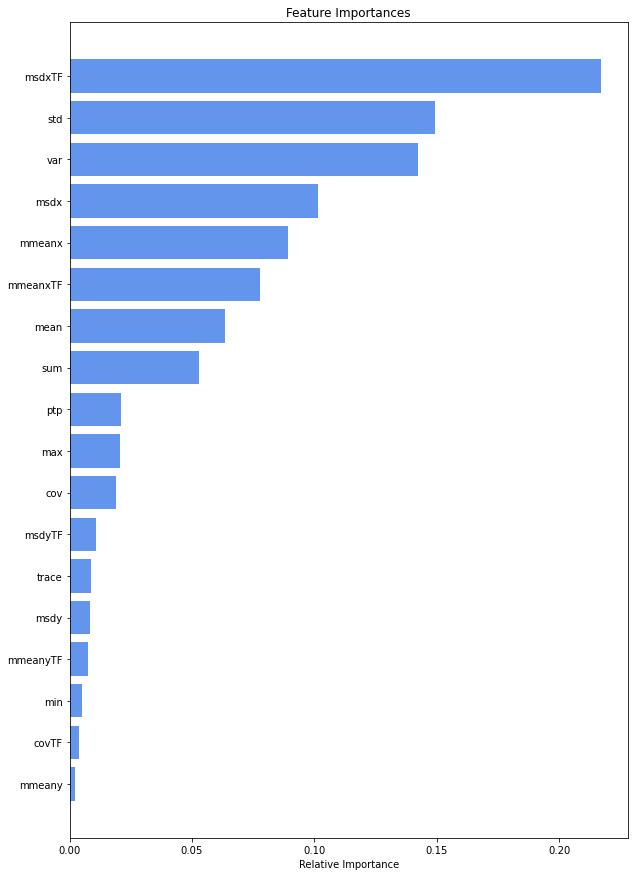

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split# Spliiting data into test and train sets

# X_train, X_test, y_train, y_test = train_test_split(features.drop('target', axis=1), features['target'], test_size=0.20, random_state=0)# fitting the model
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model.fit(features.drop('target', axis=1), features['target'])# plotting feature importances
features_forest = features.drop('target', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='cornflowerblue', align='center')
plt.yticks(range(len(indices)), [features_forest[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [8]:
X_train = features.drop('target', axis=1)
Y_train = features['target']

X_test = test_features.drop('target', axis=1)
Y_test = test_features['target']

model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model.fit(X_train, Y_train)# plotting feature importances

Y_pred = model.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(model.score(X_test, Y_test)))

confusion_matrix = confusion_matrix(test_features['target'], Y_pred)

Accuracy of random forest classifier on test set: 0.99


In [28]:
X_train = features.drop('target', axis=1)
Y_train = features['target']

X_test = test_features.drop('target', axis=1)
Y_test = test_features['target']

from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, Y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_test, Y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.97 accuracy with a standard deviation of 0.01


In [113]:
features[features_forest[indices][ifrom:]]

,std,msdxTF
0,44.595585,560.718289
1,10.582167,561.377769
2,30.961274,561.260189
3,22.701295,563.147405
4,44.611841,569.540165
...,...,...
4305,3.800286,417.780386
4306,15.952741,429.444008
4307,21.890127,420.758711
4308,23.228620,432.888399


In [36]:
features.max()

min             19.000000
max            255.000000
mean            46.207692
var           3451.601775
sum          12014.000000
ptp            255.000000
std             58.750334
trace         1440.000000
mmeanx          14.681450
mmeanxTF        19.000000
msdx           762.656101
msdxTF        1339.605539
mmeany           8.584960
mmeanyTF        12.000000
msdy           347.752355
msdyTF         517.945943
cov         122086.606474
covTF       293725.000000
target           1.000000
dtype: float64

In [18]:
ifrom = 16
print(features_forest[indices][ifrom:])

X_train = features[features_forest[indices][ifrom:]]
Y_train = features['target']

X_test = test_features[features_forest[indices][ifrom:]]
Y_test = test_features['target']

clf = sSVC()
clf.fit(X_train, Y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_test, Y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Index(['std', 'msdxTF'], dtype='object')


NameError: name 'svm' is not defined

In [100]:
features[features_forest[indices][10:]]

,sum,mean,mmeanxTF,mmeanx,msdx,var,std,msdxTF
0,6065.0,23.326923,0.000000,4.213560,431.840885,1988.766198,44.595585,560.718289
1,2780.0,10.692308,0.000000,8.858578,326.421058,111.982249,10.582167,561.377769
2,4175.0,16.057692,0.000000,5.498891,407.340586,958.600518,30.961274,561.260189
3,3501.0,13.465385,0.000000,6.395796,382.091944,515.348802,22.701295,563.147405
4,6124.0,23.553846,0.000000,3.985669,444.056612,1990.216331,44.611841,569.540165
...,...,...,...,...,...,...,...,...
4305,5333.0,20.511538,8.789707,8.739583,418.247809,14.442175,3.800286,417.780386
4306,5640.0,21.692308,10.582219,9.006124,430.660296,254.489941,15.952741,429.444008
4307,6007.0,23.103846,10.465517,9.109858,418.702475,479.177678,21.890127,420.758711
4308,5963.0,22.934615,11.199787,9.593619,423.064943,539.568802,23.228620,432.888399


Index(['sum', 'mean', 'mmeanxTF', 'mmeanx', 'msdx', 'var', 'std', 'msdxTF'], dtype='object')

In [65]:
X_train.shape

(7440, 2)

In [9]:
legal = np.concatenate((read_grayscale_pngs("out/legal/orig"), read_grayscale_pngs("out/legal/mirrored")))
illegal = np.concatenate((read_grayscale_pngs("out/illegal/orig"), read_grayscale_pngs("out/illegal/mirrored")))

legal_test = read_grayscale_pngs("testing_recurrent/legal")
illegal_test = read_grayscale_pngs("testing_recurrent/illegal")

X_train = np.empty((len(legal) + len(illegal), 2))
X_test = np.empty((len(legal_test) + len(illegal_test), 2))

i = 0
for data in (legal, illegal):
    for image in data:
        X_train[i, 0] = np.std(image)
        X_train[i, 1] = marginal.std(image, dim='x', meanNN_TF=True)

    i += 1
y_train = np.concatenate((np.full(len(legal), 0, dtype=np.uint8), np.full(len(illegal), 1, dtype=np.uint8)))

i = 0
for data in (legal_test, illegal_test):
    for image in data:
        X_test[i, 0] = np.std(image)
        X_test[i, 1] = marginal.std(image, dim='x', meanNN_TF=True)

    i += 1
y_test = np.concatenate((np.full(len(legal_test), 0, dtype=np.uint8), np.full(len(illegal_test), 1, dtype=np.uint8)))

In [11]:
legal = np.concatenate((read_grayscale_pngs("out/legal/orig"), read_grayscale_pngs("out/legal/mirrored")))
illegal = np.concatenate((read_grayscale_pngs("out/illegal/orig"), read_grayscale_pngs("out/illegal/mirrored")))

legal_test = read_grayscale_pngs("testing_recurrent/legal")
illegal_test = read_grayscale_pngs("testing_recurrent/illegal")

X_train = np.empty((len(legal) + len(illegal), 2))
X_test = np.empty((len(legal_test) + len(illegal_test), 2))



legal_features = pd.DataFrame({
    "mmeanx": np.array([marginal.mean(image, dim='x', meanNN_TF=False) for image in legal]),
    "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in legal]),
    "target": 0
})

illegal_features = pd.DataFrame({
    "mmeanx": np.array([marginal.mean(image, dim='x', meanNN_TF=False) for image in illegal]),
    "msdxTF": np.array([marginal.std(image, dim='x', meanNN_TF=True) for image in illegal]),
    "target": 1
})

features = pd.concat((illegal_features, legal_features))

X_train = features.drop('target', axis=1)
y_train = features['target']

clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [17]:
import pickle
with open("SVM_pik.obj", 'wb') as filek:
    pickle.dump(clf, filek)

TypeError: write() argument must be str, not bytes